# **Comparison between the kappa.py and wong.py modules**

This notebook contains a comparison between the modules `kappa.py` and `wong.py`. The `kappa.py` module computes the momentum accumulated by a static parton, assuming that its position is fixed and the momentum changes only by virtue of the electric fields of the Glasma. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2    
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
quark = 'charm'     
mass = 1.275     
tau_form = 1/(2*mass)*hbarc   
pT = 0.5    
ntp = 10**5  
nevents = 5    
representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,       
    'NTP' : ntp,
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_pos, init_charge, init_mom_toy

# Kappa module
import curraun.kappa as kappa

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [3]:

# Simulation routine
def simulate(p, ev): 
    mass = p['MASS']
    pT = p['PT']
    tau_form = p['TFORM']

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    tau = np.linspace(0, tau_sim, maxt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt, 4))

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, tau

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [4]:
quarks = ['beauty', 'charm']
quark_masses = [4.18, 1.27]
pTs = [0, 2, 5, 10]
# formation_times = [0.02, 0.08]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq] 

        mom_broads = []
        for ev in range(nevents):
            mom_broad_ev, tau_wong = simulate(p, ev)
            mom_broads.append(mom_broad_ev)

        mom_broad[tag] = np.mean(mom_broads, axis=0)
        tau[tag] = tau_wong

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_wong.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Beauty quark
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 828/828 [01:08<00:00, 12.14it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 828/828 [01:04<00:00, 12.78it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 828/828 [01:04<00:00, 12.79it/s]


Charm quark
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 850/850 [01:05<00:00, 12.96it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 850/850 [01:05<00:00, 12.95it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 850/850 [01:05<00:00, 12.95it/s]


## Simulation routine for the static quark case

In [3]:
def simulate_kappa(p, ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            if t>=formt:  
                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append((t-formt)*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad_kappa, tau_kappa

## Run over multiple Glasma events and do averages

In [ ]:
quarks = ['beauty', 'charm']
quark_masses = [4.18, 1.27]
pTs = [0, 2, 5, 10]
# formation_times = [0.02, 0.08]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc
    # p['TOFMR'] = formation_times[iq]

    tag = quarks[iq]
    p['FOLDER'] = su_group + '_kappa_' + quarks[iq] 

    mom_broads = []
    for ev in range(nevents):
        mom_broad_ev, tau[tag] = simulate_kappa(p, ev)
        mom_broads.append(mom_broad_ev)

    mom_broad[tag] = np.mean(mom_broads, axis=0)

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_kappa.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

## Read data from files using Julia

In [1]:
using Pickle

Qs = 2.0
results = ["wong", "kappa"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_wong["quarks"]
pTs = string.(data_wong["pTs"])

4-element Vector{String}:
 "0"
 "2"
 "5"
 "10"

## Plot the results using Makie from Julia

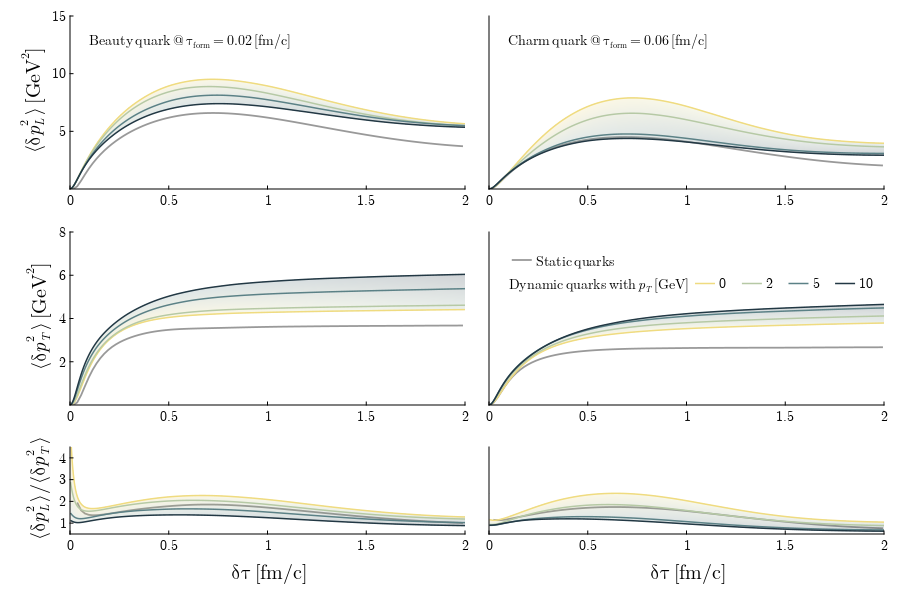

In [2]:
using CairoMakie
using ColorSchemes

# segmented_cmap = cgrad(:starrynight, 11, categorical = true)
# colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]
segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (900, 600), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle\,\mathrm{[GeV^2]}", L"\langle\delta p_T^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:3]

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 1.8, color=:grey60)
    mom_broad_T_kappa = mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2]
    lines!(axes[2][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 1.8, color=:grey60)
    ratio = mom_broad_L_kappa./mom_broad_T_kappa
    global kappa = lines!(axes[3][iq], δτ_kappa, ratio, linewidth = 1.8, color=:grey60)

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3] , mom_broad_wong[tag_high][:, 3]
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.2))
    mom_broad_T_low, mom_broad_T_high = mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2], mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2]
    band!(axes[2][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.2))
    ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
    band!(axes[3][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.2))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 1.5, color=colors[ipT])
        mom_broad_T_wong = mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2]
        lines!(axes[2][iq], δτ_wong, mom_broad_T_wong, linewidth = 1.5, color=colors[ipT])
        ratio = mom_broad_L_wong./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[3][iq], δτ_wong, ratio, linewidth = 1.5, color=colors[ipT]))
    end
end

for i in 1:3
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j], axes[3][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
        hidexdecorations!(axes[2][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], 0, 15)
ylims!(axes[1][2], 0, 15)
axes[1][1].yticks = ([5, 10, 15], string.([5, 10, 15]))
ylims!(axes[2][1], 0, 8)
axes[2][1].yticks = ([2, 4, 6, 8], string.([2, 4, 6, 8]))
ylims!(axes[3][1], 0.5, 4.5)
axes[3][1].yticks = ([1,2,3,4], string.([1, 2, 3, 4]))

rowsize!(fig.layout, 1, Relative(2/5))
rowsize!(fig.layout, 2, Relative(2/5))
rowsize!(fig.layout, 3, Relative(1/5))

legend_wong_pT = ["0", "2", "5", "10"]
axislegend(axes[2][2], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"\mathrm{Dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", labelsize=14, 
        titleposition = :left, titlesize=14, position = (0.02,0.8), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{Static\,quarks}"]
axislegend(axes[2][2], [kappa], legend_kappa, labelsize=14, position = (0.01,1), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{Beauty\,quark\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,12), textsize=14)
text!(axes[1][2], L"\mathrm{Charm\,quark\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,12), textsize=14)

display(fig)
# save("makie_mom_broad_wong_vs_kappa.png", fig, px_per_unit = 5.0) 

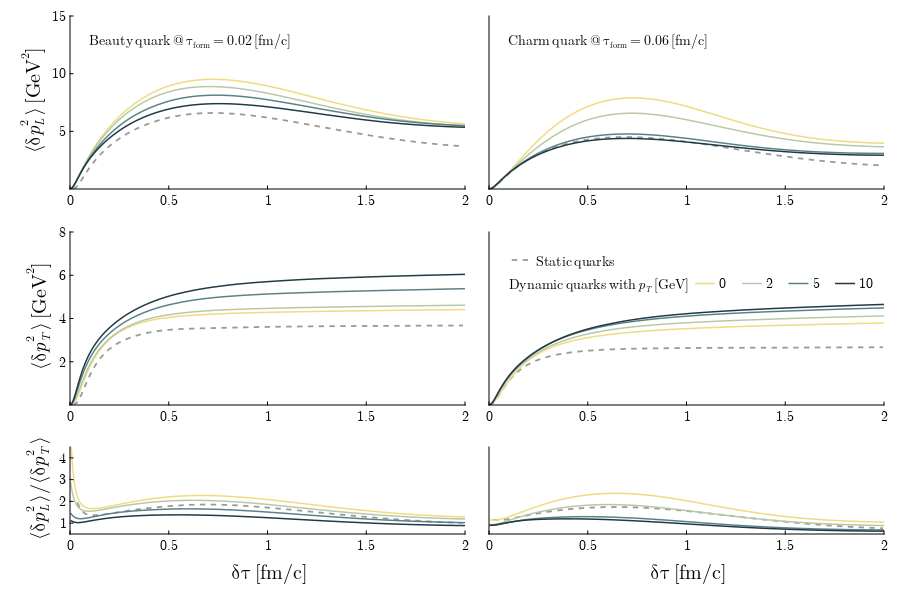

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000bb20230, 4500.0, 3000.0)


In [7]:
using CairoMakie
using ColorSchemes

# segmented_cmap = cgrad(:starrynight, 11, categorical = true)
# colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]
segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (900, 600), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle\,\mathrm{[GeV^2]}", L"\langle\delta p_T^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:3]

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 1.8, color=:grey60, linestyle=:dash)
    mom_broad_T_kappa = mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2]
    lines!(axes[2][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 1.8, color=:grey60, linestyle=:dash)
    ratio = mom_broad_L_kappa./mom_broad_T_kappa
    global kappa = lines!(axes[3][iq], δτ_kappa, ratio, linewidth = 1.8, color=:grey60, linestyle=:dash)

    # tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    # δτ_wong = Float64.(tau_wong[tag_low])
    # mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3] , mom_broad_wong[tag_high][:, 3]
    # band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:matter, 0.2))
    # mom_broad_T_low, mom_broad_T_high = mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2], mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2]
    # band!(axes[2][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.2))
    # ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
    # band!(axes[3][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.2))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 1.5, color=colors[ipT])
        mom_broad_T_wong = mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2]
        lines!(axes[2][iq], δτ_wong, mom_broad_T_wong, linewidth = 1.5, color=colors[ipT])
        ratio = mom_broad_L_wong./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[3][iq], δτ_wong, ratio, linewidth = 1.5, color=colors[ipT]))
    end
end

for i in 1:3
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j], axes[3][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
        hidexdecorations!(axes[2][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], 0, 15)
ylims!(axes[1][2], 0, 15)
axes[1][1].yticks = ([5, 10, 15], string.([5, 10, 15]))
ylims!(axes[2][1], 0, 8)
axes[2][1].yticks = ([2, 4, 6, 8], string.([2, 4, 6, 8]))
ylims!(axes[3][1], 0.5, 4.5)
axes[3][1].yticks = ([1,2,3,4], string.([1, 2, 3, 4]))

rowsize!(fig.layout, 1, Relative(2/5))
rowsize!(fig.layout, 2, Relative(2/5))
rowsize!(fig.layout, 3, Relative(1/5))

legend_wong_pT = ["0", "2", "5", "10"]
axislegend(axes[2][2], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"\mathrm{Dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", labelsize=14, 
        titleposition = :left, titlesize=14, position = (0.02,0.8), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{Static\,quarks}"]
axislegend(axes[2][2], [kappa], legend_kappa, labelsize=14, position = (0.01,1), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{Beauty\,quark\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,12), textsize=14)
text!(axes[1][2], L"\mathrm{Charm\,quark\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,12), textsize=14)

display(fig)
save("makie_mom_broad_wong_vs_kappa_qm22.png", fig, px_per_unit = 5.0) 